# Fashion-MNIST Classification with an LDA Head
This notebook trains a small convolutional encoder with a linear discriminant analysis (LDA) head on Fashion-MNIST, then visualises the learned embedding space.


### Setup


In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from src.lda import TrainableLDAHead, DiagTrainableLDAHead, FullCovLDAHead, DNLLLoss

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

device = cuda


### Data


In [3]:
tfm = transforms.ToTensor()
train_ds = datasets.FashionMNIST(root='./data', train=True, transform=tfm, download=True)
test_ds  = datasets.FashionMNIST(root='./data', train=False, transform=tfm, download=True)
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
test_ld  = DataLoader(test_ds,  batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)
len(train_ds), len(test_ds)

(60000, 10000)

### Model: encoder + LDA head (on-the-fly stats)


In [4]:
class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.proj = nn.Linear(256, dim)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.proj(x)

class DeepLDA(nn.Module):
    def __init__(self, C, D):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = DiagTrainableLDAHead(C, D)
    def forward(self, x):
        z = self.encoder(x)
        return self.head(z)


### Train & Eval


In [5]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ok = tot = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)  # EMA stats
        ok += (logits.argmax(1) == y).sum().item()
        tot += y.size(0)
    return ok / tot

model = DeepLDA(C=10, D=9).to(device)
opt = torch.optim.Adam(model.encoder.parameters())
#loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
#loss_fn = LDALoss()
loss_fn = DNLLLoss(lambda_reg=.01)
#loss_fn = LogisticLoss()

for epoch in range(1, 101):
    model.train()
    loss_sum = acc_sum = n_sum = 0
    for x, y in train_ld:
        x, y = x.to(device), y.to(device)
        logits = model(x)        # uses batch stats + EMA update
        loss = loss_fn(logits, y)
        opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
        with torch.no_grad():
            pred = logits.argmax(1)
            acc_sum += (pred == y).sum().item()
            n_sum += y.size(0)
            loss_sum += loss.item() * y.size(0)
    tr_acc = acc_sum / n_sum
    te_acc = evaluate(model, test_ld)
    print(f"[{epoch:02d}] train loss={loss_sum/n_sum:.4f} acc={tr_acc:.4f} | test acc={te_acc:.4f}")

[01] train loss=4.9597 acc=0.8157 | test acc=0.8400
[02] train loss=3.9853 acc=0.8974 | test acc=0.8582
[03] train loss=3.7357 acc=0.9144 | test acc=0.8876
[04] train loss=3.5739 acc=0.9249 | test acc=0.8867
[05] train loss=3.4585 acc=0.9324 | test acc=0.9111
[06] train loss=3.3379 acc=0.9401 | test acc=0.9111
[07] train loss=3.2410 acc=0.9474 | test acc=0.9160
[08] train loss=3.1523 acc=0.9541 | test acc=0.9032
[09] train loss=3.0807 acc=0.9599 | test acc=0.8968
[10] train loss=2.9973 acc=0.9658 | test acc=0.9159
[11] train loss=2.9471 acc=0.9701 | test acc=0.9215
[12] train loss=2.8442 acc=0.9762 | test acc=0.9191
[13] train loss=2.7925 acc=0.9815 | test acc=0.9291
[14] train loss=2.7172 acc=0.9852 | test acc=0.9307
[15] train loss=2.6674 acc=0.9885 | test acc=0.9270
[16] train loss=2.6308 acc=0.9910 | test acc=0.9232
[17] train loss=2.5837 acc=0.9933 | test acc=0.9278
[18] train loss=2.5367 acc=0.9952 | test acc=0.9288
[19] train loss=2.5192 acc=0.9964 | test acc=0.9185
[20] train l

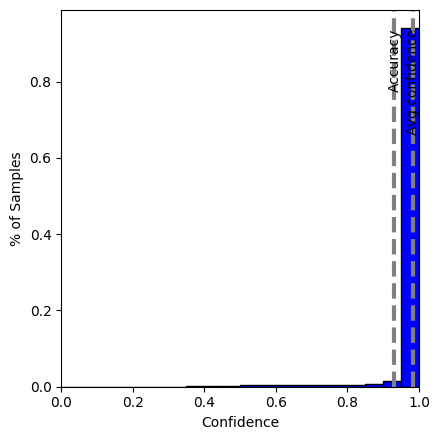

In [6]:
import numpy as np
import matplotlib.pyplot as plt

model.eval()
conf_list = []
pred_list = []
label_list = []
with torch.no_grad():
    for x, y in test_ld:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        conf, pred = probs.max(1)
        conf_list.append(conf.cpu())
        pred_list.append(pred.cpu())
        label_list.append(y.cpu())

conf = torch.cat(conf_list).numpy()
pred = torch.cat(pred_list)
labels = torch.cat(label_list)
acc = (pred == labels).float().mean().item()
avg_conf = conf.mean().item()

bins = np.linspace(0.0, 1.0, 21)
weights = np.ones_like(conf) / conf.size

plt.figure(figsize=(4.5, 4.5))
plt.hist(conf, bins=bins, weights=weights, color='blue', edgecolor='black')
plt.axvline(avg_conf, color='gray', linestyle='--', linewidth=3)
plt.axvline(acc, color='gray', linestyle='--', linewidth=3)
plt.text(avg_conf, 0.95 * plt.gca().get_ylim()[1], 'Avg confidence',
         rotation=90, va='top', ha='center')
plt.text(acc, 0.95 * plt.gca().get_ylim()[1], 'Accuracy',
         rotation=90, va='top', ha='center')
plt.xlabel('Confidence')
plt.ylabel('% of Samples')
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig('plots/fashion_mnist_confidence_hist.png', dpi=600)


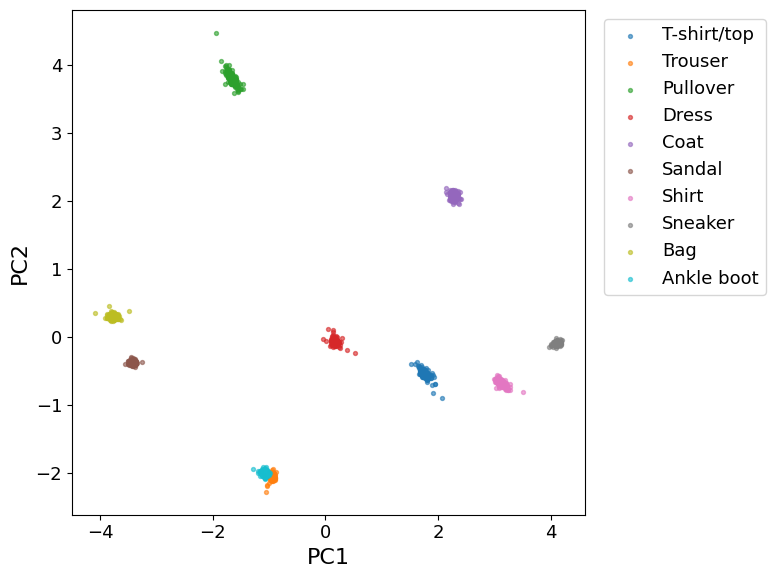

In [7]:
import matplotlib.pyplot as plt

model.eval()
embeds, labels = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(train_ld):   # use train_ld if you prefer
        x = x.to(device)
        z = model.encoder(x).cpu()
        embeds.append(z)
        labels.append(y)
        if i >= 9:   # 10 batches ≈10k points; raise/lower to taste
            break

z = torch.cat(embeds)
y = torch.cat(labels)

# 2D projection (PCA)
z0 = z - z.mean(0, keepdim=True)
U, S, V = torch.pca_lowrank(z0, q=2)
z2 = z0 @ V[:, :2]

plt.rcParams.update({
    "font.size": 14, "axes.labelsize": 16, "legend.fontsize": 13,
    "xtick.labelsize": 13, "ytick.labelsize": 13
})

plt.figure(figsize=(8, 6))
for c in range(10):
    idx = y == c
    plt.scatter(z2[idx, 0], z2[idx, 1], s=8, alpha=0.6, label=train_ds.classes[c])
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig('plots/fashion_mnist_lda_embeddings.png', dpi=600)
